In [1]:
import pandas as pd
import nltk
import lightgbm
import yellowbrick
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
from gensim.models import Word2Vec



stopwords = set(stopwords.words('english'))
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train['text_raw'] = train['text']

# Clean

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def metrics(m): 
    # AUC
    vis = yellowbrick.ROCAUC(m, classes=[0,1])
    vis.fit(X_train,y_train)
    vis.score(X_test,y_test)
    vis.show()

    # F1 Score
    scores = cross_val_score(m, X_train, y_train, cv=3, scoring='f1')
    print(scores.mean())

    # # Heatmap
    # preds = m.predict(X_test)
    # sns.heatmap(confusion_matrix(y_test.tolist(),preds), cmap='rocket_r',annot=True)
    # plt.show()

# TFIDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    stop_words=stopwords, 
    ngram_range=(1,1),
    lowercase=True,
    max_features=1000 
    )
train_vectors = vec.fit_transform(train['text_raw'])

# Cluster 

In [14]:
from sklearn.cluster import KMeans
k = KMeans(
    n_clusters=2,
    random_state=0,
    )
k.fit(train_vectors)
X = pd.DataFrame(train_vectors.todense())
X['cluster'] = k.labels_

# View Clusters

<AxesSubplot:xlabel='0', ylabel='1'>

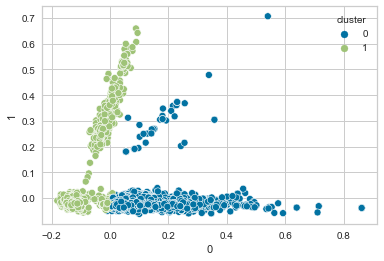

In [15]:
from sklearn.decomposition import PCA
t = X.iloc[:,:-1]
pca = PCA(n_components=2)
z = pd.DataFrame(pca.fit_transform(t))
z['cluster'] = k.labels_
sns.scatterplot(x=z[0], y=z[1],  hue=z['cluster'])

# Adding Features

In [16]:
extra = ['location','keyword']
X['location'] = train['location']
X['keyword'] = train['keyword']

# Label Encoding

In [17]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(X)
X = pd.DataFrame(ohe.transform(X).todense(), columns=ohe.get_feature_names_out())

C:\Users\crysi\anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\crysi\anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


# Normalization

In [18]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()


pca = PCA(n_components = 100)
X = pd.DataFrame(scale.fit_transform(X))
X = pd.DataFrame(pca.fit_transform(X, ))

# Train Test Split

In [19]:
df = X.copy()
# With KMeans + TFIDF
feat_names = (list(vec.get_feature_names_out()))
feat_names.append('cluster')
feat_names.append('keyword')
feat_names.append('location')
# df.columns = feat_names
X_train,X_test,y_train,y_test = train_test_split(
                                        X, # df 
                                        train['target'],
                                        stratify=train['target'], 
                                        random_state=0, 
                                        test_size=.2,
                                        
                                        )

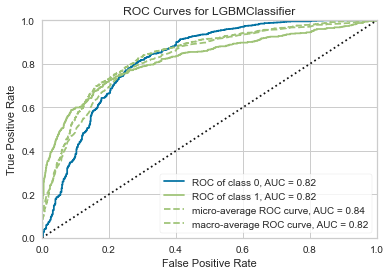

0.7072750263219213


In [20]:
# With like 0.6943139623816387
m = lightgbm.LGBMClassifier(
    num_leaves=30,
    max_depth=-1,
    n_estimators=100,
    learning_rate=.14
)
# m = RandomForestClassifier()
m.fit(X_train, y_train)
metrics(m)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

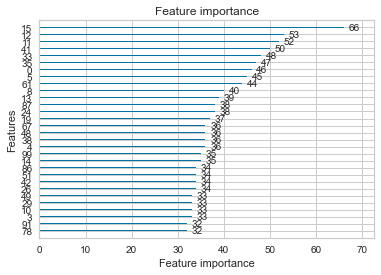

In [21]:
lightgbm.plot_importance(m, max_num_features=30, )

# ON Test Set

In [22]:
df = X.copy()
m = lightgbm.LGBMClassifier(
    num_leaves=30,
    max_depth=-1,
    n_estimators=100,
    learning_rate=.14)

# FULL TRAIN SET
clusters = k.predict(train_vectors)
# X.drop(columns=[x for x in X.columns if 'û' in x])
m.fit(df, train['target'])

LGBMClassifier(learning_rate=0.14, num_leaves=30)

In [31]:
# Transform Test DATA
test_vectors = vec.transform(test['text'])
clusters = k.predict(test_vectors)

In [32]:
df = pd.DataFrame(test_vectors.todense())
df['cluster'] = clusters
df['location'] = test['location']
df['keyword'] = test['location']

In [35]:
df = pd.DataFrame(ohe.transform(df).todense(), columns=ohe.get_feature_names_out())
# preds = m.predict(df)
# test['target'] = preds
# test.set_index('id')['target'].to_csv('tt.csv')

C:\Users\crysi\anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


ValueError: Found unknown categories [0.2180254940926812, 0.28292256383718595, 0.283355580488886, 0.29266101084355817, 0.297350518821274, 0.31040297145569773, 0.3358414018442112, 0.33996688049545054, 0.34163477459916497, 0.3806713674430352, 0.45721838013653104, 0.4737538474405619, 0.5009710254130577] in column 0 during transform